# Description:

* Demultiplexing libraries from MiSeq run

## Setting variables (user input)

In [1]:
import os

seqdir = '/home/backup_files/raw_reads/hempmicrobiome.Sam.Ali.SmartLab.2018/'
workdir = '/home/sam/notebooks/hemp_microbiome/data/OTU_pipeline_output/'

# metadata file location(s)
metadata = 'metadata_16S.txt'

index_read1_file = 'index1.16S.fq.gz'
index_read2_file = 'index2.16S.fq.gz'
read12_screed = 'pear_merged-2018-03-30.assembled.fastq_screed'
index_read1_screed = 'index1.16S.fq_screed'
index_read2_screed = 'index1.16S.fq_screed'

## Init

In [2]:
import os
import json
import screed
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import screed
from glob import glob

In [3]:
%cd $workdir

/home/sam/notebooks/hemp_microbiome/data/OTU_pipeline_output


In [4]:
%load_ext rpy2.ipython
#%load_ext pushnote 

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


## Loading metadata tables

In [6]:
# loading metadata sheet
df_meta = pd.read_csv(workdir+metadata, delimiter="\t")
print(df_meta.head(n=3))

  sample_ID  Extraction_plate Extraction_plate_well  Dilution_plate  \
0    1-2-RT  hemp_DNAx_plate1                    A1  hemp_DI_plate1   
1     6-5-F  hemp_DNAx_plate1                    B1  hemp_DI_plate1   
2     2-3-L  hemp_DNAx_plate1                    C1  hemp_DI_plate1   

  Dilution_plate_well  PCR_run  PCR_order  Primer        Library     Exp_type  \
0                  A1        1          1       1  hemp_library1  whole_plant   
1                  B1        1          2       2  hemp_library1  whole_plant   
2                  C1        1          3       3  hemp_library1  whole_plant   

         Field  Plant  Sample_type  Week  Sex  DNA_conc  Date_extracted  \
0      McGowan    2.0  root_tissue   NaN  NaN     1.712          180111   
1    Freeville    5.0      flowers   NaN  NaN     0.065          180111   
2  East_Ithaca    3.0       leaves   NaN  NaN     0.126          180111   

   DI_factor    Index1    Index2  
0      1.712  ATCGTACG  AACTCTCG  
1      1.000  ACTAT

# Uncompress index files and create screed db

In [7]:
def uncomp(fileName, directory):
    output = fileName.replace(".gz", "")
    fileName = directory+fileName
    !cd $workdir; \
        pigz -k -d -p 24 -c -f $fileName > $output
    return os.path.splitext(output)[0]
    
index_read1_file = uncomp(index_read1_file, seqdir)
index_read2_file = uncomp(index_read2_file, seqdir)

In [8]:
os.chdir(workdir)
screed.read_fastq_sequences(index_read1_file+".fq")
screed.read_fastq_sequences(index_read2_file+".fq")

index_read1_screed = index_read1_file + '.fq_screed'
index_read2_screed = index_read2_file + '.fq_screed'

# Demultiplex

In [9]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)    

In [10]:
# loading/editing metadata

df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.Index1,df_meta.Index2)]


## format of barcode=>sample dict: [revBarcode=read1 + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [11]:
# resulting dict of sample => barcode_FR 
n_print = 96
[(list(map_d.keys())[i], map_d[list(map_d.keys())[i]]) for i in range(n_print)]

[('cgagagttatcgtacg', '1-2-RT'),
 ('cgagagttactatctg', '6-5-F'),
 ('cgagagtttagcgagt', '2-3-L'),
 ('cgagagttctgcgtgt', '1-4-RS'),
 ('cgagagtttcatcgag', 'F2-1'),
 ('cgagagttcgtgagtg', 'M5-3'),
 ('cgagagttggatatct', '3-3-BS'),
 ('cgagagttgacaccgt', '6-1-RT'),
 ('gacatagtatcgtacg', '5-5-BS'),
 ('gacatagtactatctg', 'F4-2'),
 ('gacatagttagcgagt', '5-3-RS'),
 ('gacatagtctgcgtgt', 'extraction_water_control1'),
 ('gacatagttcatcgag', '1-2-L'),
 ('gacatagtcgtgagtg', 'F5-1'),
 ('gacatagtggatatct', '1-4-RT'),
 ('gacatagtgacaccgt', '6-3-BS'),
 ('acgctactatcgtacg', '4-3-BS'),
 ('acgctactactatctg', '3-3-L'),
 ('acgctacttagcgagt', '3-4-BS'),
 ('acgctactctgcgtgt', 'M2-3'),
 ('acgctacttcatcgag', '2-3-F'),
 ('acgctactcgtgagtg', 'F1-3'),
 ('acgctactggatatct', '6-1-F'),
 ('acgctactgacaccgt', '4-4-L'),
 ('actcactgatcgtacg', '4-3-L'),
 ('actcactgactatctg', '2-4-RS'),
 ('actcactgtagcgagt', '4-4-RS'),
 ('actcactgctgcgtgt', '3-4-L'),
 ('actcactgtcatcgag', '4-5-F'),
 ('actcactgcgtgagtg', '2-4-BS'),
 ('actcactggg

In [12]:
# loading screed databases 
ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed)

In [13]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workdir, os.path.split(outFile)[1])
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["quality"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print ("Unable to assign %s reads to samples"%unassigned)

Unable to assign 3967273 reads to samples


In [14]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print('Number of sequences: {}'.format(n_lines/4))

Number of sequences: 12638894.0


# Stats on sequences

## Number of sequences per sample

In [15]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [16]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(seq_cnt, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,1-4-RS,78670
1,2-1-RS,253049
2,2-5-RT,86135
3,3-1-RT,126725
4,2-4-L,11226
5,3-2-BS,120812
6,M2-1,51819
7,M5-3,61918
8,6-1-RT,169328
9,F4-1,74068


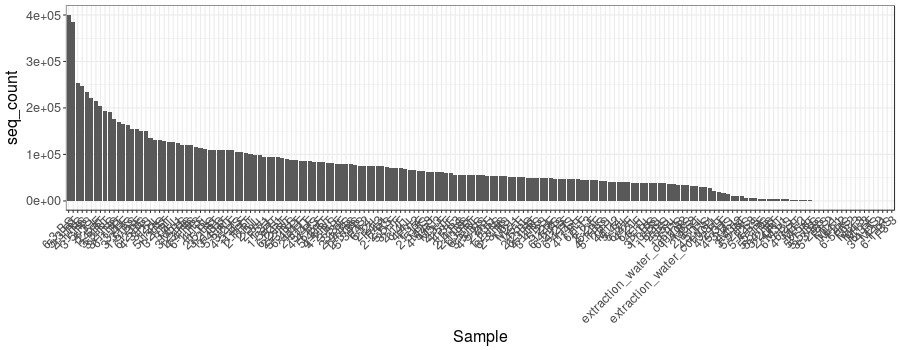

In [17]:
%%R -i df_seq_cnt -w 900 -h 350

df_seq_cnt$Sample = reorder(df_seq_cnt$Sample, desc(df_seq_cnt$seq_count))

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [18]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

    Sample seq_count
41    F1-1       164
86  5-2-RT      4210
129 5-4-RS      4212
142   F2-3      6143
151 3-5-RT      9700
153 5-4-BS      5495
154 5-5-RS      4430
155   F2-2       296
156  6-2-L      2168
157 5-2-RS      6747
158 6-5-RS       278
159  5-1-F      5117
160 2-4-RT      3786
161  6-3-F       226
162 6-5-BS      3278
163 5-1-RT       969
164   M3-1      3290
165  6-5-L      1221
166 5-2-BS       540
167 5-5-BS       654
168 4-3-RT      2023
169   M4-2      1805
170 3-3-BS       637
171   M1-1       391
172 6-1-BS       138
173   M1-3       230
174   F1-2       513
175   F5-2       276
176   M3-3       274
177 3-4-RS       218
178   M4-1       381
179   F3-3       125
180   M4-3       250
181   M2-2       167
